In [139]:
suppressWarnings(suppressMessages({
    library(tidyverse)
    library(lme4)
    library(effects)
    library(gtsummary)
    library(lubridate)
    library(nlme)
    library(sjPlot)
    library(fastDummies)
}))

In [7]:
metrics_fit <- read.csv("~/datamining-analysis/osat/gitignore/metrics_fit_for_save.csv")

In [8]:
metrics_fit <- metrics_fit %>%
    group_by(BID, time_factor) %>%
    slice_head()

dim(metrics_fit)

[1] 106   6

In [9]:
metrics_fit$StudyGroup <- as.numeric(as.factor(metrics_fit$StudyGroup))
metrics_fit$time_factor <- as.numeric(as.factor(metrics_fit$time_factor))

$# time_factor = {1, 2, 3, 4}
  StudyGroup = {1, 2}
  Y = Hmotnost
  BID = 1 , ... , 31 $

#### time_factor = {1, 2, 3, 4}
#### StudyGroup = {1, 2}
####  Y = Hmotnost
####  BID = 1 , ... , 31 

`geom_smooth()` using formula = 'y ~ x'


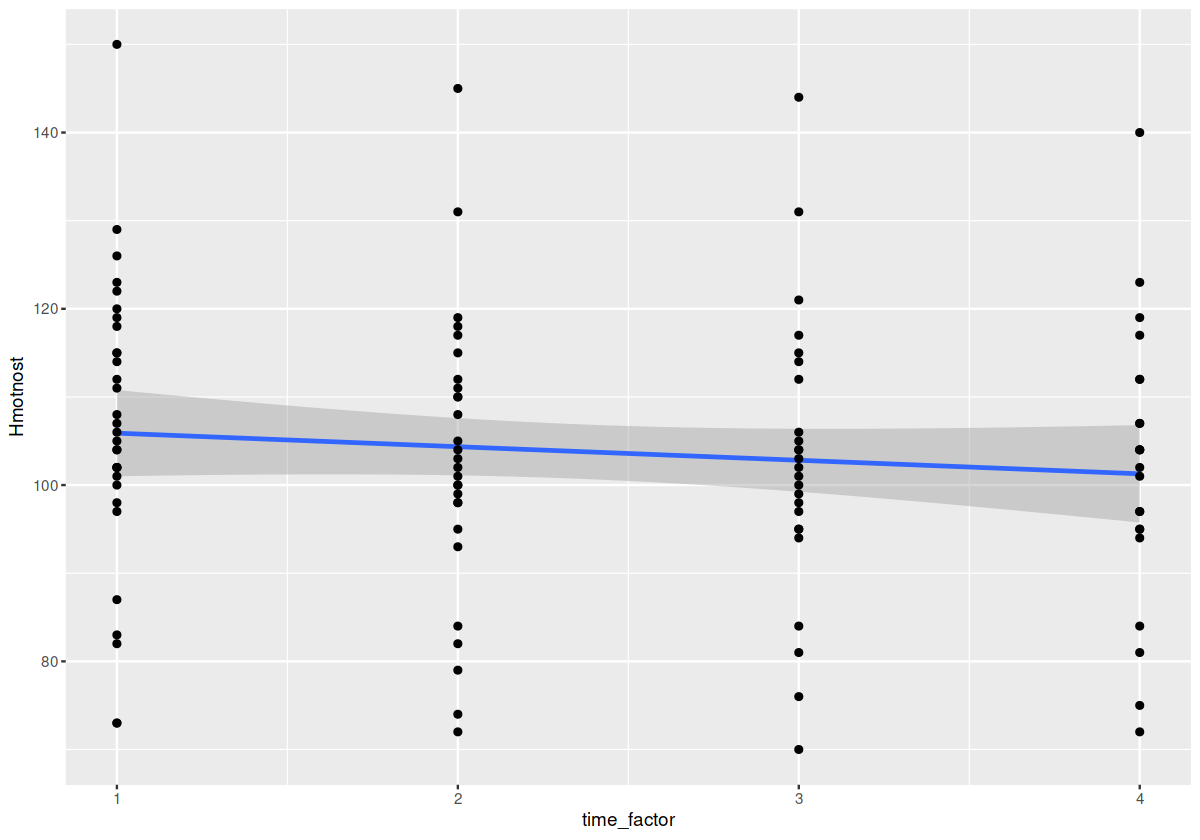

In [1603]:
options(repr.plot.width=10, repr.plot.height=7)

ggplot(metrics_fit, aes(x=time_factor,y=value1)) + 
    geom_smooth(method = "lm") + 
    geom_point() +
    ylab("Hmotnost")

In [1613]:
# OLS 
ols <- lm(value1 ~ 1, metrics_fit)
summary(ols)

# paste("Mean weight = ", mean(metrics_fit$value1))


Call:
lm(formula = value1 ~ 1, data = metrics_fit)

Residuals:
    Min      1Q  Median      3Q     Max 
-33.802  -6.802   0.198   9.698  46.198 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  103.802      1.562   66.47   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.08 on 105 degrees of freedom


##### $$ b = (X^{T}X)^{-1}X^{T}y $$

In [1629]:
# maticovy vypocet interceptu b0

Y = as.matrix(metrics_fit %>%
                select(value1) %>% pull)
X = as.matrix(rep(1, length(Y)))
b0 = solve(t(X) %*% X) %*% t(X) %*% Y 

b0

Adding missing grouping variables: `BID`, `time_factor`


103.8019


#### $$ t = \frac{b_{0}}{ SE } $$
##### $$ SE = \sqrt{var(e)*(X^{T}X)^{-1} } $$

In [1622]:
e = Y - X %*% b0
SE = sqrt(var(e) %*% solve(t(X) %*% X))
t = b0 / SE
paste("t = ", t)

[1] "t =  66.4748234525267"

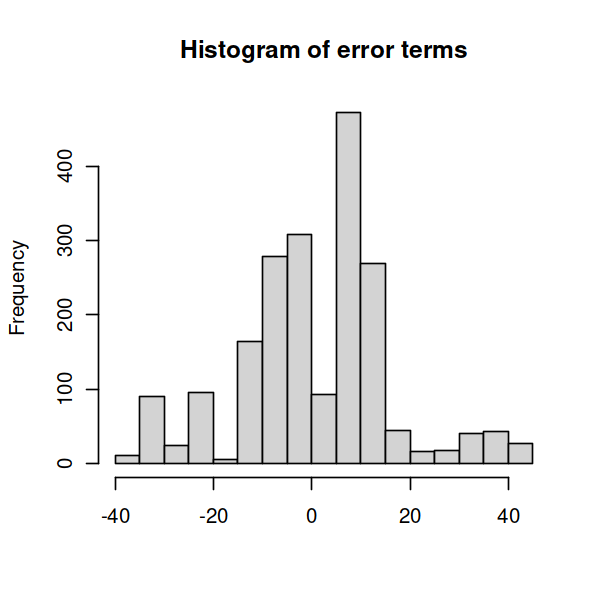

In [16]:
options(repr.plot.width=5, repr.plot.height=5)

hist(e, main = "Histogram of error terms", xlab = "")

 #### Mixed models
 
 $$ Y = Xb + ZU + e $$

 $$ Y \sim N(Xb, \sigma^{2}I + ZDZ^{T}) $$
 
  $$ e \sim N(0, \sigma^{2}) $$
  
   $$ u \sim N(0, D) $$

####  1. For each BID calulate random intercept (ML method) as follows:

##### $$ u_{i} = D Z_{i}^{T} V^{-1}_{i} e_{i} $$
##### $ i $ = number of values for each BID

### EM algorithm

#### E - step

In [ ]:
# set priors (E-step):

b = 0 
sigma = 1 
D = matrix(1) 

#### M - step


##### $$ b_{t+1} = (\sum X_{i}^{T} W_{i} X_{i})^{-1}\sum (X_{i}^{T} W_{i} y_{i}) $$

##### $$ D_{t+1} = (\sum u_{t}u_{t}^{T} + D(I - Z_{t}^{T} W_{t} Z_{t} D_{t}) $$


##### $$ sigma_{t+1} = \frac{ \sum(e_{t}e_{t}^{T} + sigma_{t} tr(I - sigma_{t} W_{t})}{N}  $$


In [1916]:
# for BID 1 estimate random intercept

# Y = as.matrix(metrics_fit %>% 
#                 filter(BID == unique(BID)[1]) %>% 
#                 select(value1) %>% pull)


# X = rep(1, length(Y)) # 1 x 46
# Z = rep(1, length(Y)) # 1 x 46 
# I = diag(length(Y)) # 46 x 46

# V = sigma * I + Z %*% D %*% t(Z) # 46 x 46 
# W = solve(V)


# r = Y - (X) %*% t(b) # (y - Xb) residual from ols r=Y
# # calculate random intercept for BID1
# u = D %*% t(Z) %*% W %*% r
# u
#   e = r - (Z %*% u) 
  
#   # for b recalculation 
#   cov_list = c(cov_list, t(X) %*% W %*% Y)
#   var_list = c(var_list, t(X) %*% W %*% X) # (3.3)
  
#   # for sigma and D recalculation 
#   sigma_list = c(sigma_list, t(e) %*% e + sigma * sum(diag(I - sigma * W)))
#   D_list = c(D_list, u %*% t(u) + D * (diag(1) - t(Z) %*% W %*% Z %*% D))

#### In a same way estimate random intercept for each BID with priors (b=0, sigma = 1, D = matrix(1)).
#### Saving each random intercept $ u_{i} $ and residual variance $ e_{ij} $, 
#### where $ i $ = 1, ... , 31

In [1920]:
# ML
# loop across every BID
  
D = matrix(1)
sigma = 1
b = 0

b_values <- c()
sigma_values <- c()
D_values <- c()

bids <- unique(metrics_fit$BID)

In [1921]:
n = 10

for (j in 1:n) { 
    
  sigma_list <- c()
  D_list <- c()
  cov_list <- c()
  var_list <- c()
  
for (bid in 1:length(unique(metrics_fit$BID))) {
  
  Y = as.matrix((metrics_fit %>% 
                filter(BID == bids[bid]))$value1)

  X = matrix(rep(1,nrow(Y)))
  Z = rep(1, nrow(Y))
  I = diag(nrow(Y))
  
  V = sigma * I + Z %*% D %*% t(Z)
  W =  solve(V)
  
  r = Y - (X) %*% t(b) # (y - Xb)
  u = D %*% t(Z) %*% W %*% r # (3.2) (u = r in a balanced dataset)
  e = r - (Z %*% u) 
  
  # for b recalculation 
  cov_list = c(cov_list, t(X) %*% W %*% Y)
  var_list = c(var_list, t(X) %*% W %*% X) # (3.3)
  
  # for sigma and D recalculation 
  sigma_list = c(sigma_list, t(e) %*% e + sigma * sum(diag(I - sigma * W)))
  D_list = c(D_list, u %*% t(u) + D * (diag(1) - t(Z) %*% W %*% Z %*% D)) #  D * (diag(1) - t(Z) %*% W %*% Z %*% D) = 0 in a balanced dataset

}
    
# recalculate b
b = solve(sum(var_list)) %*% sum(cov_list)
# and recalculate sigma
sigma = sum(sigma_list)/nrow(metrics_fit)
# and recalculate D
D = diag(sum(D_list)/length(D_list), 1)
    

b_values[j] = b
sigma_values[j] = sigma
D_values[j] = D
}

In [1922]:
c(D, sigma, b) 

[1] 243.05596  10.86734 104.16031

In [1711]:
summary(lmer.mod.ML)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: value1 ~ 1 + (1 | BID)
   Data: metrics_fit

     AIC      BIC   logLik deviance df.resid 
   692.3    700.3   -343.2    686.3      103 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.57609 -0.52824 -0.09361  0.28133  2.67231 

Random effects:
 Groups   Name        Variance Std.Dev.
 BID      (Intercept) 243.07   15.591  
 Residual              10.86    3.295  
Number of obs: 106, groups:  BID, 31

Fixed effects:
            Estimate Std. Error t value
(Intercept)  104.160      2.822   36.91

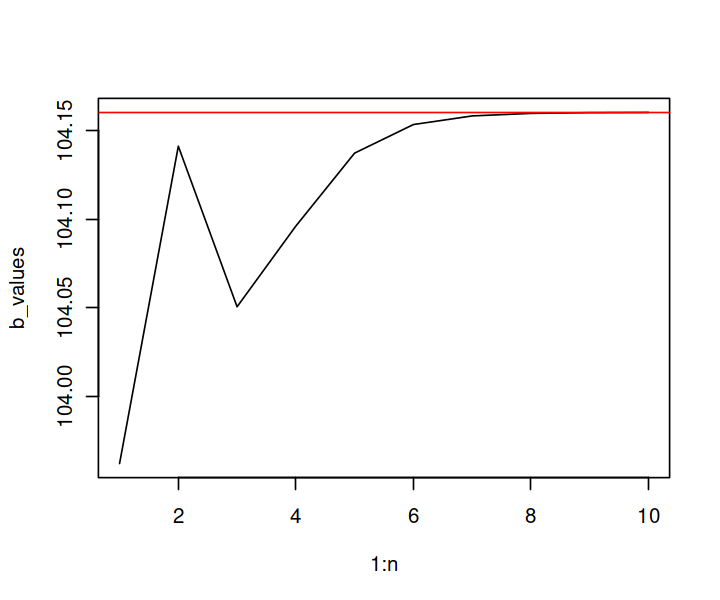

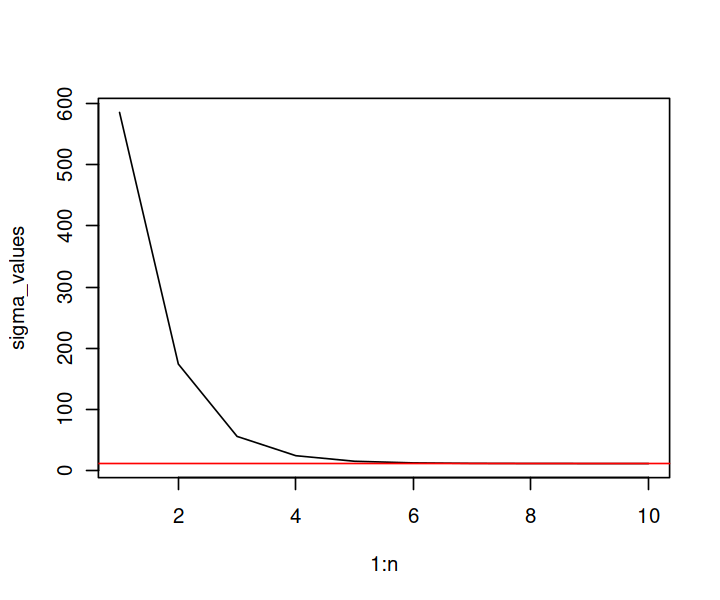

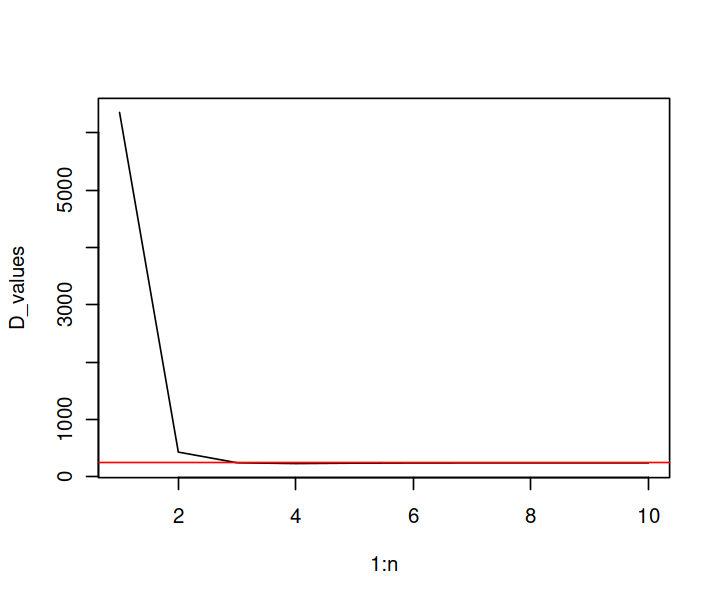

In [1923]:
options(repr.plot.width=6, repr.plot.height=5)

plot(1:n, b_values, type="l")
abline(h=b, col='red')
plot(1:n, sigma_values, type="l")
abline(h=sigma(lmer.mod.ML)^2, col='red')
plot(1:n, D_values, type="l")
abline(h=VarCorr(lmer.mod.ML)[[1]]%>% as.vector(), col='red')

In [1645]:
# REML
# loop across every BID
  
D = matrix(1)
sigma = 1
b = 0

b_values <- c()
sigma_values <- c()
D_values <- c()

In [1646]:
n = 10

for (j in 1:n) { 
    
  sigma_list <- c()
  D_list <- c()
  cov_list <- c()
  var_list <- c()
  
for (bid in 1:length(unique(metrics_fit$BID))) {
  
  Y = as.matrix((metrics_fit %>% 
                filter(BID == bids[bid]))$value1)

  X = as.matrix(rep(1,nrow(Y)))
  Z = rep(1, nrow(Y))
  I = diag(nrow(Y))
  
  V = sigma * I + Z %*% D %*% t(Z)
  W =  solve(V)
  P = W %*% (I - X %*% solve(sum(t(X) %*% W %*% X)) %*% t(X) %*% W) # (3.10)
  # P = W - W %*% X %*% solve(sum(t(X) %*% W %*% X)) %*% t(X) %*% W # (3.10)
 
  r = Y - (X) %*% t(b) # (y - Xb)
  u = D %*% t(Z) %*% P %*% r # (3.2)
  e = r - (Z %*% u) 
  
  # for b recalculation 
  cov_list = c(cov_list, t(X) %*% W %*% Y)
  var_list = c(var_list, t(X) %*% W %*% X) # (3.3)
  
  # for sigma and D recalculation 
  sigma_list = c(sigma_list, t(e) %*% e + sigma * sum(diag(I - sigma * P)))
  D_list = c(D_list, u %*% t(u) + D %*% (diag(1) - t(Z) %*% P %*% Z %*% D)) 
}
    
# recalculate b
b = solve(sum(var_list)) %*% sum(cov_list)
# and recalculate sigma
sigma = sum(sigma_list)/nrow(metrics_fit)
# and recalculate D
D = diag(sum(D_list)/length(bid), 1)
    

b_values[j] = b
sigma_values[j] = sigma
D_values[j] = D
}

In [1647]:
c(D, sigma, b)

[1] 8.196258e+14 3.622212e+02 1.041801e+02

#### $$ P = W (I - X \sum(X^{T}WX)^{-1}X^{T}W $$

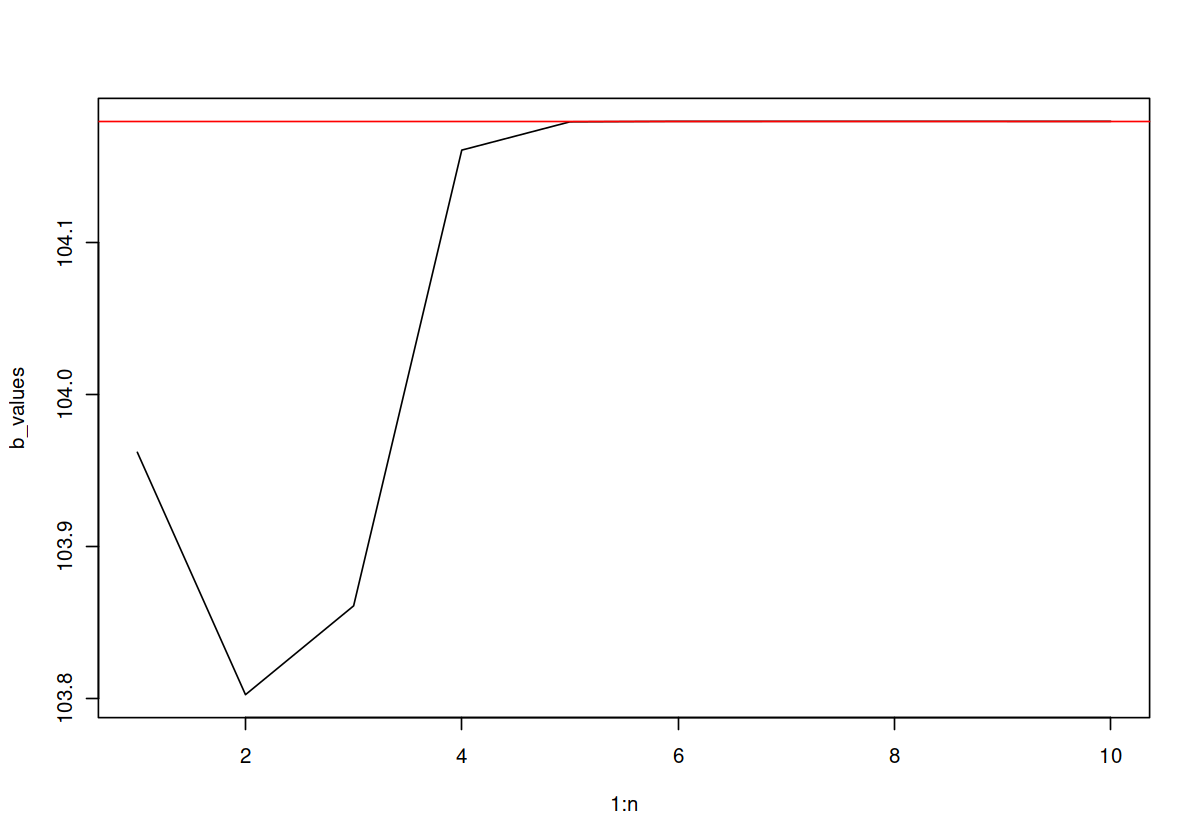

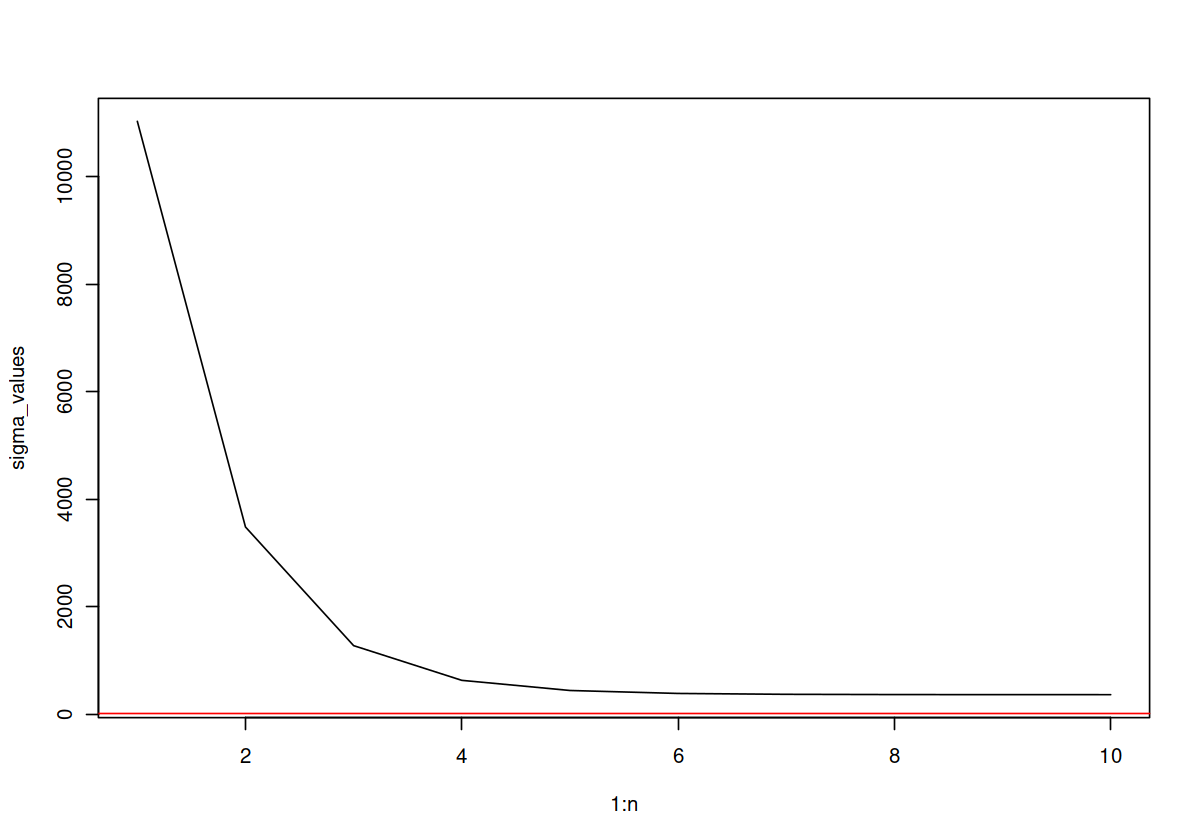

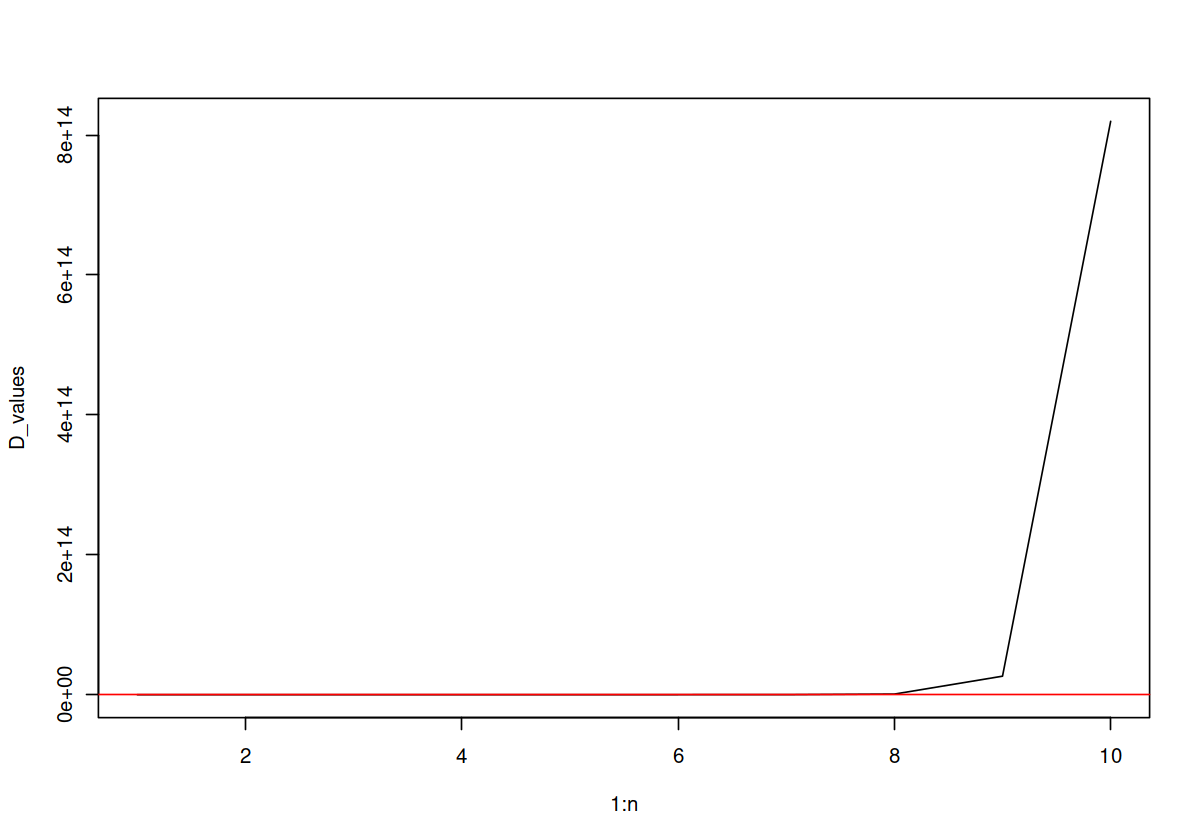

In [1648]:
plot(1:n, b_values, type="l")
abline(h=b, col='red')
plot(1:n, sigma_values, type="l")
abline(h=sigma(lmer.mod.REML)^2, col='red')
plot(1:n, D_values, type="l")
abline(h=VarCorr(lmer.mod.REML)[[1]]%>% as.vector(), col='red')

In [1924]:
# ML
# rucne
  
D = matrix(1)
sigma = 1
b = 0

b_values <- c()
sigma_values <- c()
D_values <- c()

In [1937]:
sigma_list <- c()
D_list <- c()
cov_list <- c()
var_list <- c()
  
for (bid in 1:length(unique(metrics_fit$BID))) {
  
  Y = as.matrix((metrics_fit %>% 
                filter(BID == bids[bid]))$value1)

  X = as.matrix(rep(1,nrow(Y)))
  Z = rep(1, nrow(Y))
  I = diag(nrow(Y))
  
  V = sigma * I + Z %*% D %*% t(Z)
  W =  solve(V)
  
  r = Y - (X) %*% t(b) # (y - Xb)
  u = D %*% t(Z) %*% W %*% r # (3.2)
  e = r - (Z %*% u) 
  
  # for b recalculation 
  cov_list = c(cov_list, t(X) %*% W %*% Y)
  var_list = c(var_list, t(X) %*% W %*% X) # (3.3)
  
  # for sigma and D recalculation 
  sigma_list = c(sigma_list, t(e) %*% e + sigma * sum(diag(I - sigma * W)))
  D_list = c(D_list, u %*% t(u) + D * (diag(1) - t(Z) %*% W %*% Z %*% D))

}
    
# recalculate b
b = solve(sum(var_list)) %*% sum(cov_list)
# and recalculate sigma
sigma = sum(sigma_list)/nrow(metrics_fit)
# and recalculate D
D = diag(sum(D_list)/length(D_list), 1)

paste('(ML) sigma =', sigma)
paste('(ML) b =', b)
paste('(ML) D =', D)

[1] "(ML) sigma = 10.8595534260243"

[1] "(ML) b = 104.160361480628"

[1] "(ML) D = 243.064939992393"

In [1680]:
lmer.mod.ML = lmer(value1 ~ 1 + (1|BID), data = metrics_fit, REML = F)
summary(lmer.mod.ML)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: value1 ~ 1 + (1 | BID)
   Data: metrics_fit

     AIC      BIC   logLik deviance df.resid 
   692.3    700.3   -343.2    686.3      103 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.57609 -0.52824 -0.09361  0.28133  2.67231 

Random effects:
 Groups   Name        Variance Std.Dev.
 BID      (Intercept) 243.07   15.591  
 Residual              10.86    3.295  
Number of obs: 106, groups:  BID, 31

Fixed effects:
            Estimate Std. Error t value
(Intercept)  104.160      2.822   36.91

In [1818]:
# REML
# rucne
  
D = matrix(1)
sigma = 1
b = 0

b_values <- c()
sigma_values <- c()
D_values <- c()

In [1819]:
sigma_list <- c()
D_list <- c()
cov_list <- c()
var_list <- c()
  
for (bid in 1:length(unique(metrics_fit$BID))) {
  
  Y = as.matrix((metrics_fit %>% 
                  filter(BID == unique(BID)[bid]))$value1)

  X = as.matrix(rep(1,nrow(Y)))
  Z = rep(1, nrow(Y))
  I = diag(nrow(Y))
  
  V = sigma * I + Z %*% D %*% t(Z)
  W =  solve(V)
  P = W %*% (I - X %*% solve(sum(t(X) %*% W %*% X)) %*% t(X) %*% W) # (3.10)
    
  r = Y - (X) %*% t(b) # (y - Xb)
  u = D %*% t(Z) %*% W %*% r # (3.2)
  e = r - (Z %*% u) 
  
  # for b recalculation 
  cov_list = c(cov_list, t(X) %*% W %*% Y)
  var_list = c(var_list, t(X) %*% W %*% X) # (3.3)
  
  # for sigma and D recalculation 
  sigma_list = c(sigma_list, t(e) %*% e + sigma * sum(diag(I - sigma * P)))
  D_list = c(D_list, u %*% t(u) + D * (diag(1) - t(Z) %*% P %*% Z %*% D)) 

}
    
# recalculate b
b = solve(sum(var_list)) %*% sum(cov_list)
# and recalculate sigma
sigma = sum(sigma_list)/nrow(metrics_fit)
# and recalculate D
D = diag(sum(D_list)/length(D_list), 1)

paste('(REML) sigma =', sigma)
paste('(REML) b =', b)
paste('(REML) D =', D)

ERROR: Error in solve.default(V): 'a' is 0-diml


In [1681]:
lmer.mod.REML = lmer(value1 ~ 1 + (1|BID), data = metrics_fit, REML = TRUE)
summary(lmer.mod.REML)

Linear mixed model fit by REML ['lmerMod']
Formula: value1 ~ 1 + (1 | BID)
   Data: metrics_fit

REML criterion at convergence: 682.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.57663 -0.52832 -0.09549  0.28081  2.67173 

Random effects:
 Groups   Name        Variance Std.Dev.
 BID      (Intercept) 251.28   15.852  
 Residual              10.86    3.295  
Number of obs: 106, groups:  BID, 31

Fixed effects:
            Estimate Std. Error t value
(Intercept)  104.161      2.869   36.31

$$
\begin{bmatrix}
R_{1} & 0 & \cdots & 0 \\
0 & R_{2} & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & R_{n}
\end{bmatrix} \tag{3-8}
$$

### VarCov matrix

#### Compound symmetry

In [1823]:
# compound symmetry structure with lme

fit <- lme(value1 ~ factor(time_factor), 
            random = ~1|BID,  
            data = metrics_fit,
            method="ML")

VarCorr(fit)

BID = pdLogChol(1) 
            Variance   StdDev   
(Intercept) 242.461784 15.571184
Residual      6.224912  2.494977

In [1907]:
# round(getVarCov(fit, type= "marginal", individual = 1)[[1]],2)
getVarCov(fit, type= "marginal", individual = 24)

BID 561209/0440 
Marginal variance covariance matrix
       1      2      3      4
1 248.69 242.46 242.46 242.46
2 242.46 248.69 242.46 242.46
3 242.46 242.46 248.69 242.46
4 242.46 242.46 242.46 248.69
  Standard Deviations: 15.77 15.77 15.77 15.77 

$$
\begin{bmatrix}
\sigma^{2} + \tau & \tau & \cdots & \tau \\
\tau & \sigma^{2} + \tau & \cdots & \tau \\
\vdots & \vdots & \ddots & \vdots \\
\tau & \tau & \cdots & \sigma^{2} + \tau
\end{bmatrix} \tag{3-8}
$$

#### Unstructured

In [24]:
metrics_fit$time_factor <- as.factor(metrics_fit$time_factor)

In [26]:
#  unstructured covariance matrix

fit2 <- lme(value1 ~ factor(time_factor), 
            random = ~(time_factor)|BID, 
            data = metrics_fit,
            method="ML")

In [27]:
# ...getVarCov doesnt give the correct matrix (r cant be negative)

getVarCov(fit2) 

Random effects variance covariance matrix
             (Intercept) time_factor2 time_factor3 time_factor4
(Intercept)      260.740     -16.4860      -19.516      -26.668
time_factor2     -16.486       9.6021       13.072       13.207
time_factor3     -19.516      13.0720       19.880       21.910
time_factor4     -26.668      13.2070       21.910       26.510
  Standard Deviations: 16.147 3.0987 4.4587 5.1487 

In [28]:
# ...getVarCov doesnt give the correct matrix (r cant be negative)

getVarCov(fit2)[1:4,1:4]

,(Intercept),time_factor2,time_factor3,time_factor4
(Intercept),260.74005,-16.486354,-19.51645,-26.66753
time_factor2,-16.48635,9.602065,13.07216,13.20717
time_factor3,-19.51645,13.072160,19.88021,21.91041
time_factor4,-26.66753,13.207172,21.91041,26.50960


In [38]:
D <- getVarCov(fit2, type ="random") # D
d <- dummy_cols((metrics_fit %>% filter(BID==unique(BID)[1]))$time_factor)[,-c(1,2)]
Z <- cbind(rep(1,5), as.matrix(d)[1:5,])
Z

,.data_2,.data_3,.data_4
1,0,0,0
1,1,0,0
1,0,1,0
1,0,0,1
1,0,0,0


 $$ Y \sim N(Xb,  \sigma^{2}I + ZDZ^{T}) $$

In [36]:
# this one is correct unstructured matrix

sigma(fit2)*diag(5) + (Z) %*% as.matrix(D) %*% t(Z)

261.5320,244.2537,241.2236,234.0725,260.7400
244.2537,238.1614,237.8094,230.7933,244.2537
241.2236,237.8094,242.3793,236.4665,241.2236
234.0725,230.7933,236.4665,234.7066,234.0725
260.7400,244.2537,241.2236,234.0725,261.5320


#### AR(1)

In [1858]:
#  ar(1) covariance matrix

fit3 <- lme(value1 ~ factor(time_factor), 
    random = ~1|BID, 
    correlation = corAR1(form = ~1|BID),
    data = metrics_fit)

In [1859]:
corMatrix(fit3$modelStruct$corStruct)[[1]]

1.0000000,0.9865659,0.9733122,0.9602366
0.9865659,1.0000000,0.9865659,0.9733122
0.9733122,0.9865659,1.0000000,0.9865659
0.9602366,0.9733122,0.9865659,1.0000000


In [1804]:
AIC(fit) # compound symmetry

[1] 692.3451

In [1856]:
AIC(fit2) # AR(1) structure

[1] 622.4103

In [1835]:
AIC(fit3) # unstructured 

[1] 626.25

In [1851]:
#  ar(1) covariance matrix

fit3 <- lme(value1 ~ as.factor(time_factor), 
        random = ~as.factor(time_factor)|BID, 
        correlation = corAR1(form = ~1|BID),
        data = metrics_fit)

$$
\sigma^{2} \begin{bmatrix}
1 & \rho & \rho^{2} & \rho^{3} \\
\rho & 1 & \rho & \rho^{2} \\
\rho^{2} & \rho & 1 & \rho \\
\rho^{3} & \rho^{2} & \rho & 1
\end{bmatrix} \tag{3-8}
$$

In [1945]:
round(corMatrix(fit3$modelStruct$corStruct)[[1]], 3)

1.000,0.165,0.027,0.005
0.165,1.000,0.165,0.027
0.027,0.165,1.000,0.165
0.005,0.027,0.165,1.000


In [1947]:
0.165^2

[1] 0.027225

In [1853]:
AIC(fit3)

[1] 623.5491